In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
from backtest import preprocess
import statsmodels.api as sm

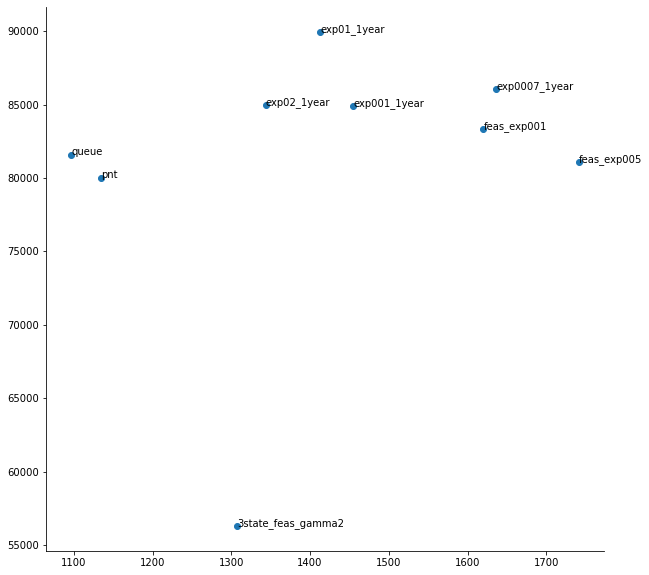

In [2]:
fig, ax = plt.subplots(figsize=(10,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
lams = ['01','1','2','5','10','50','100']
obj = 'i'
out = []
# for lam in lams:
#     name = '3state_gamma_'+lam
#     pth = os.path.join('res',name,obj,'sum.csv')
#     res = pd.read_csv(pth)
#     # res = res[res.date<20220322]
#     out.append([name, res.drl.sum(),res.avg_drl_sec.mean()])
oths = ['baseline','queue', 'feas_exp005', '3state_feas_gamma2', 'feas_exp001']
onames = ['pnt','queue', 'feas_exp005', '3state_feas_gamma2','feas_exp001']
for oth, onames in zip(oths, onames):
    pth = os.path.join('res',oth,obj,'sum.csv')
    res = pd.read_csv(pth)
    # res = res[res.date<20220322]
    out.append([onames, res.drl.sum(),res.drl.std()])
lams = ['01','001','02','0007']
for lam in lams:
    name = 'exp'+lam+'_1year'
    pth = os.path.join('res',name,obj,'sum.csv')
    res = pd.read_csv(pth)
    # res = res[res.date<20220322]
    out.append([name, res.drl.sum(),res.drl.std()])

out = pd.DataFrame(out, columns=['name','cost','stde'])
ax.scatter(out.stde, out.cost)
for a, b, c in zip(out.name, out.stde, out.cost):
    ax.annotate(a,xy=(b,c))


# avgr = [i.avgR.mean() for i in hd.values()]
# stdr = [i.stdR.mean() for i in hd.values()]
# ax.plot(stdr, avgr, 'o-', label='hd')
# for text, x, y in zip([30, 50, 100, 200, 500, 600], stdr, avgr):
#     ax.annotate(f'hd{text}', xy=(x,y), xytext=(x+0.1,y-0.01))
#     # ax.annotate(f'({round(x,2)} {round(y,2)})', xy=(x,y), xytext=(x+0.001,y-0.05))
# avgr = [i.avgR.mean() for i in lv.values()]
# stdr = [i.stdR.mean() for i in lv.values()]
# ax.plot(stdr, avgr, 'o-', label='lv')
# for text, x, y in zip([1, 2, 3, 5, 7, 10, 20], stdr, avgr):
#     ax.annotate(f'lv{text}', xy=(x,y), xytext=(x-0.1,y+0.01))
#     # ax.annotate(f'({round(x,2)} {round(y,2)})', xy=(x,y), xytext=(x+0.001,y-0.05))
# x = agent.stdR.mean()
# y = agent.avgR.mean()
# ax.scatter(x,y)
# ax.annotate(f'DRL agent', xy=(x,y), xytext=(x-0.1,y-0.02))
# plt.xlabel('stdR')
# plt.ylabel('avgR')
# plt.legend()
# # ax.plot(hd30.avgR)
# # ax.plot(hd30.stdR)

<BarContainer object of 0 artists>

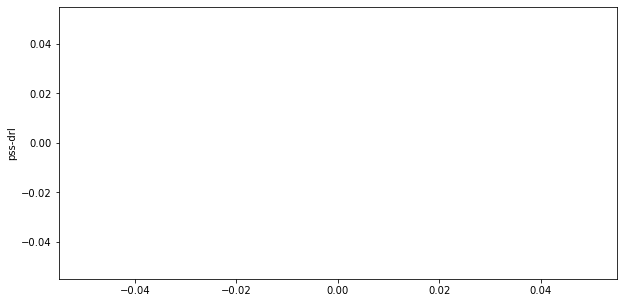

In [3]:
# data = pd.read_csv('symbol_instrumentid2.csv')
# objs = data.pz.unique()
objs = ['rb', 'bu', 'OI', 'i']
a, b, c = 0, 0, 0
fin = []
cha = []
for obj in objs:
    if os.path.exists(f'res/{obj}/trade/sum.csv'):
        fin.append(obj)
        data = pd.read_csv(f'res/{obj}/trade/sum.csv')
        a+=data.drl.sum()
        b+=data.pss.sum()
        c+=data['agg'].sum()
        cha.append((obj, data.pss.sum()-data.drl.sum()))
cha = sorted(cha, key=lambda x:x[1])
a, b = [x[0] for x in cha], [x[1] for x in cha]
plt.subplots(figsize=(10,5))
plt.ylabel('pss-drl')
plt.bar(a, b)
# data = data[data.date!=20220119]

[4 2]
       summ        stdd
0   61900.0  123.858025
1   61700.0  122.254840
2   63300.0  117.820140
3   70550.0   91.594017
4   67400.0  108.058035
5   66950.0   93.850456
6   58850.0   49.725625
7   59200.0  112.417219
8   64050.0  123.448935
9   59300.0   40.918389
10  60750.0  128.103532
-0.0034576036638151366 338.5498588652675


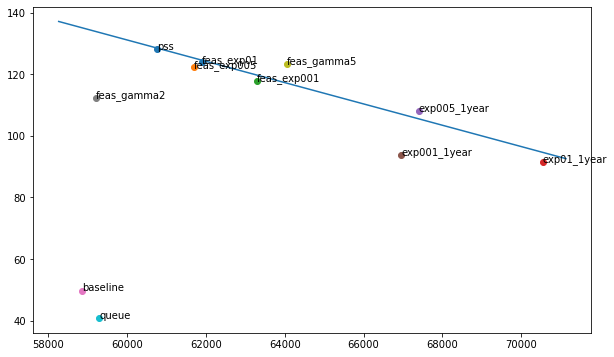

In [22]:
from sklearn.linear_model import RANSACRegressor 
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
fig, ax=plt.subplots(figsize=(10,6))
# obj = 'OI'
models = ['feas_exp01','feas_exp005','feas_exp001','exp01_1year', 'exp005_1year','exp001_1year', 'baseline', 'feas_gamma2', 'feas_gamma5', 'queue']
# models = ['exp002_fea', 'exp004_fea', 'exp001_fea','exp008_fea', 'exp003_fea', '3state_feas_gamma2','baseline', 'exp01_1year','exp001_1year','exp0005_fea','exp0007_1year','queue','queue_agg']
# models = ['exp0005_fea','exp001_fea','exp002_fea','exp003_fea', 'exp004_fea', 'exp008_fea', 'exp016_fea','baseline_fea']#, '3state_feas_gamma2','baseline', 'exp01_1year','exp001_1year','exp0007_1year','queue','queue_agg']
dd = pd.read_csv('symbol_instrumentid2.csv')
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
objs = ['i']
# models = models+['3state_gamma_2','3state_gamma_5','3state_gamma_10','3state_gamma_50','queue']
# models = ['feas_exp01','exp01_1year']
for obj in objs:
    pth = os.path.join('res','exp016_fea',obj)
    pss = []
    summary = []
    for _, __, files in os.walk(pth):
        for file in files:
            if file.split('.')[0]!='sum' and int(file.split('.')[0])<20220322:
                data = pd.read_csv(os.path.join(pth, file))
                # data = data[data.date<20220322]
                # print(data)
                pss.append(data.pss.values)
    for model in models:
        pth = os.path.join('res',model,obj)
        drls = []
        for _, __, files in os.walk(pth):
            for file in files:
                if file.split('.')[0]!='sum' and int(file.split('.')[0])<20220322:
                    data = pd.read_csv(os.path.join(pth, file))
                    # data = data[data.date<20220322]
                    drls.append(data.drl.values)
        # print(model, obj)
        drls = np.concatenate(drls)
        # print(model, drls.sum(), drls.std())
        summary.append([drls.sum(), drls.std()])
        ax.scatter(drls.sum(), drls.std())
        ax.annotate(model, xy=(drls.sum(), drls.std()))
        # ax.plot(np.sort(drls)[-2000:],label=model)
    pss = np.concatenate(pss)
    # print('pss', pss.sum(), pss.std())
    summary.append([pss.sum(),pss.std()])
    ax.scatter(pss.sum(), pss.std())
    ax.annotate('pss', xy=(pss.sum(), pss.std()))
    # ax.plot(np.sort(pss)[-2000:],label='pss')
    summary = pd.DataFrame(summary,columns=['summ','stdd'])

    x = sm.add_constant(summary.summ)
    model = sm.OLS(summary.stdd, x).fit()
    cooks = model.get_influence().cooks_distance[0]
    abnormal = cooks.argsort()[:2]
    print(abnormal)
    print(summary)
    # mod = RANSACRegressor(max_trials=1000, stop_probability=0.9999)
    # mod = TheilSenRegressor()
    mod = LinearRegression()
    mod.fit(summary.summ.values.reshape(-1,1), summary.stdd)
    coef, inte = mod.estimator_.coef_[0], mod.estimator_.intercept_
    # coef, inte = mod.coef_[0], mod.intercept_
    print(coef, inte)
    x = ax.axis()[:2]
    y1 = x[0]*coef+inte
    y2 = x[1]*coef+inte
    # dt = pd.DataFrame([[x1, y1],[x2,y2]])
    y = [y1, y2]
    ax.plot(x,y)
    # print(dt)
    # print(ax.axis())
    # alls.append([obj, summary.corr().iloc[1,0]])

In [6]:
import statsmodels.api as sm
x = sm.add_constant(summary.summ)
model = sm.OLS(summary.stdd, x).fit()
print(model.summary())
model.get_influence().cooks_distance

                            OLS Regression Results                            
Dep. Variable:                   stdd   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.106
Method:                 Least Squares   F-statistic:                    0.1348
Date:                Fri, 24 Jun 2022   Prob (F-statistic):              0.723
Time:                        14:17:44   Log-Likelihood:                -32.826
No. Observations:                  10   AIC:                             69.65
Df Residuals:                       8   BIC:                             70.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6652     30.895      0.928      0.3

/home/hongyuan/miniconda3/envs/drl/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


(array([0.04020476, 0.0872039 , 1.02507958, 0.07824499, 0.0267746 ,
        0.49011133, 0.01728786, 0.05019576, 0.0432176 , 0.12373529]),
 array([0.96078555, 0.91734933, 0.40148395, 0.9254367 , 0.97366752,
        0.62981286, 0.98289733, 0.95134033, 0.957925  , 0.88527225]))

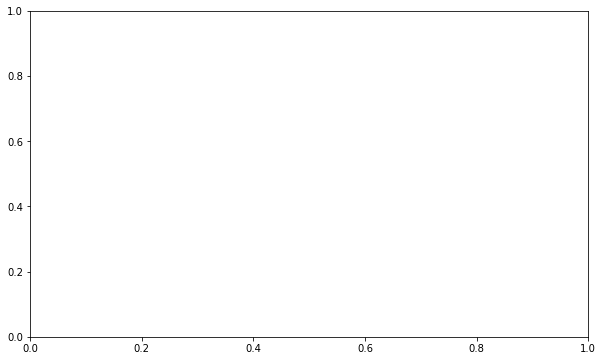

In [272]:
fig, ax=plt.subplots(figsize=(10,6))
# obj = 'OI'
# models = ['feas_exp01','feas_exp005','feas_exp001','exp01_1year', 'exp005_1year','exp001_1year', 'baseline', 'feas_gamma2', 'feas_gamma5']
# models = ['3state_feas_gamma2','baseline','exp01_1year','exp001_1year','exp0005_fea','exp0007_1year','queue','queue_agg']
models = ['exp002_fea', 'exp004_fea', 'exp008_fea','3state_feas_gamma2','baseline', 'exp01_1year','exp001_1year','exp0005_fea','exp0007_1year','queue','queue_agg']
dd = pd.read_csv('symbol_instrumentid2.csv')
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
objs = [i for i in dd.pz.unique()]
tmps = []
# objs = ['sc']
# models = models+['3state_gamma_2','3state_gamma_5','3state_gamma_10','3state_gamma_50','queue']
# models = ['feas_exp01','exp01_1year']
alls = []
for obj in objs:
    pth = os.path.join('res','exp0007_1year',obj)
    pss = []
    summary = []
    for _, __, files in os.walk(pth):
        for file in files:
            if file.split('.')[0]!='sum' and int(file.split('.')[0])>=20220101 \
                and int(file.split('.')[0])<20220301:
                data = pd.read_csv(os.path.join(pth, file))
                # data = data[data.date<20220322]
                # print(data)
                pss.append(data.pss.values)
    # print(obj)
    for model in models:
        pth = os.path.join('res',model,obj)
        drls = []
        for _, __, files in os.walk(pth):
            for file in files:
                if file.split('.')[0]!='sum' and int(file.split('.')[0])>=20220101 \
                    and int(file.split('.')[0])<20220301:
                    data = pd.read_csv(os.path.join(pth, file))
                    # data = data[data.date<20220322]
                    drls.append(data.drl.values)
        # print(model, obj)
        drls = np.concatenate(drls)
        # print(model, drls.sum(), drls.std())
        summary.append([drls.sum(), drls.std()])
        # ax.scatter(drls.sum(), drls.std())
        # ax.annotate(model, xy=(drls.sum(), drls.std()))
        # ax.plot(np.sort(drls)[-2000:],label=model)
    pss = np.concatenate(pss)
    # print('pss', pss.sum(), pss.std())
    summary.append([pss.sum(),pss.std()])
    summary = pd.DataFrame(summary,columns=['summ','stdd'])

    mod = RANSACRegressor(max_trials=1000, stop_probability=0.9999)
    # mod = TheilSenRegressor()
    mod.fit(summary.summ.values.reshape(-1,1), summary.stdd)
    coef, inte = mod.estimator_.coef_[0], mod.estimator_.intercept_
    # ax.scatter(pss.sum(), pss.std())
    # ax.annotate('pss', xy=(pss.sum(), pss.std()))
    # ax.plot(np.sort(pss)[-2000:],label='pss')
    # alls.append([obj, coef])
    if pss.sum() == summary.summ.min():
        continue
    # tmps.append(obj)
    alls.append([obj, coef])
    # print(obj, summary.corr())

In [273]:
tt = [i[0] for i in sorted(alls, key=lambda x:x[1]) if i[1]>0]

1225809.9487304688 1341275.0 1478634.9999999998


149790.05126953128

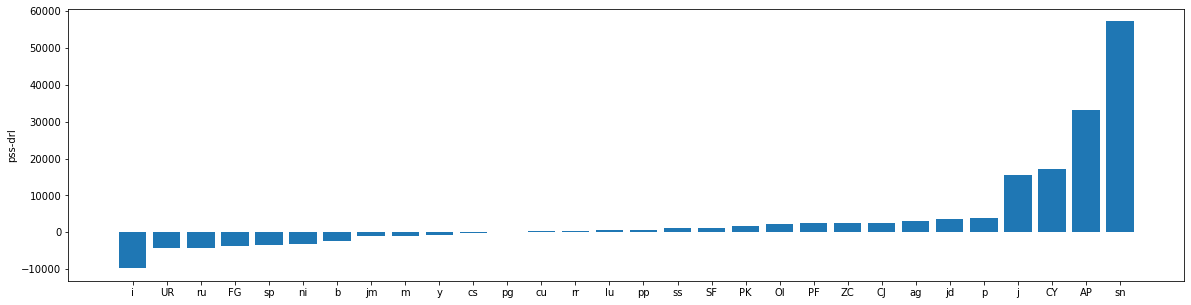

In [277]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
objs = ['rb', 'bu', 'OI', 'i']
# objs = ['rb','CF','nr','sc','al','UR','fu','MA','c','SR','y','TA','eg','v','SA','FG','ru','zn','eb','a','SF','T','au','PK','TF','l','bu']
dd = pd.read_csv('symbol_instrumentid2.csv')
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
# objs = objs+['all_list_'+i for i in objs]
objs = dd.pz.unique()
objs = tt
# rest_objs = []
comment = 'exp004_fea'
# comment = 'queue'
cwd = os.path.join('res', comment)
a, b, c = 0, 0, 0
fin = []
cha = []
for obj in objs:
    file_path = os.path.join(cwd, obj, 'sum.csv')
    # file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
    if os.path.exists(file_path):
        fin.append(obj)
        data = pd.read_csv(file_path)
        data = data[data.date<20220401]
        data = data[data.date>=20220101]
        a+=data.drl.sum()
        b+=data.pss.sum()
        c+=data['agg'].sum()
        cha.append((obj, data.pss.sum()-data.drl.sum()))
# for obj in rest_objs:
#     # file_path = os.path.join(cwd, obj, 'sum.csv')
#     file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
#     if os.path.exists(file_path):
#         fin.append(obj)
#         data = pd.read_csv(file_path)
#         a+=data.drl.sum()
#         b+=data.pss.sum()
#         c+=data['agg'].sum()
#         cha.append((obj, data.pss.sum()-data.drl.sum()))
cha = sorted(cha, key=lambda x:x[1])
# data = data[data.date!=20220119]
print(a,b,c)
a, b = [x[0] for x in cha], [x[1] for x in cha]
plt.subplots(figsize=(20,5))
plt.ylabel('pss-drl')
plt.bar(a, b)
sum([i for i in b if i > 0])

In [52]:
sorted(alls, key=lambda x:x[1])

[['TA', -0.9666902738548431],
 ['l', -0.877715597616199],
 ['SR', -0.8540201964699877],
 ['eg', -0.7923075222719861],
 ['rb', -0.703202550767512],
 ['MA', -0.6732163988384929],
 ['a', -0.5806764150061585],
 ['SA', -0.5745783459540962],
 ['fu', -0.5081819791506421],
 ['v', -0.4903785298184605],
 ['PK', -0.45602677595741314],
 ['FG', -0.44305040430631293],
 ['T', -0.42434716224488606],
 ['zn', -0.37733833438313064],
 ['b', -0.3692322431761281],
 ['y', -0.3466159590344275],
 ['eb', -0.31609488708101885],
 ['bu', -0.29411323026968245],
 ['c', -0.26545478011691837],
 ['nr', -0.2606109497565186],
 ['al', -0.20447844586726585],
 ['rr', -0.14009104627811772],
 ['CF', -0.08311726192343835],
 ['m', -0.04923921353151385],
 ['ss', -0.01572709945125866],
 ['TF', -0.005528187822065744],
 ['ru', -0.0017955773946820533],
 ['SM', 0.05403128444315422],
 ['au', 0.056492322472391984],
 ['sc', 0.09434196256583224],
 ['hc', 0.1938985582074624],
 ['lh', 0.234902811792657],
 ['cu', 0.23560493539161514],
 ['PF

In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
objs = ['rb', 'bu', 'OI', 'i']
objs = ['rb','CF','nr','sc','al','UR','fu','MA','c','SR','y','TA','eg','v','SA','FG','ru','zn','eb','a','SF','T','au','PK','TF','l','bu']
dd = pd.read_csv('symbol_instrumentid2.csv')
rest_objs = [i for i in dd.pz.unique() if i not in objs]
objs = [i for i in dd.pz.unique()]
best_para = []
# rest_objs = []
for obj in objs:
    ma = 1e9
    for comment in ['baseline', 'exp0007_1year', 'exp001_1year', 'exp01_1year', 'queue', 'queue_agg']:
        a = 0
        b = 0
        cwd = os.path.join('res', comment)
        file_path = os.path.join(cwd, obj, 'sum.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            # data = data[data.date<20220201]
            a+=data.drl.sum()
            b+=data.pss.sum()
        if a < ma:
            ma = a
            ct = comment
        best_para.append((obj,comment,a))
    best_para.append((obj,'pss',b))


In [29]:
best_para = pd.DataFrame(best_para,columns=['obj','cmt','cost'])
best_para[best_para.obj=='sc']
tmp = best_para.groupby('obj').cost.min()
pd.merge(best_para, tmp, on=['obj','cost']).to_csv('test.csv')

770455.0754595548 738357.5000000003 1092180.0000000016


<BarContainer object of 56 artists>

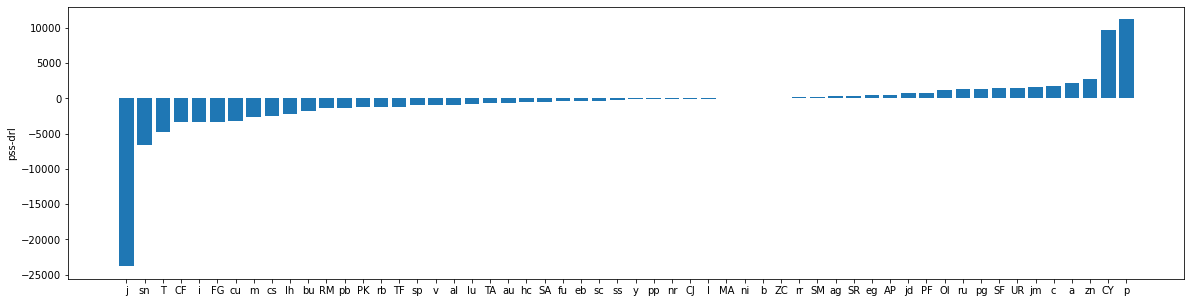

In [420]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
objs = ['rb', 'bu', 'OI', 'i']
objs = ['rb','CF','nr','sc','al','UR','fu','MA','c','SR','y','TA','eg','v','SA','FG','ru','zn','eb','a','SF','T','au','PK','TF','l','bu']
dd = pd.read_csv('symbol_instrumentid2.csv')
rest_objs = [i for i in dd.pz.unique() if i not in objs]
objs = [i for i in dd.pz.unique()]
obj_list = ['SM',
 'au',
 'hc',
 'lh',
 'cu',
 'PF',
 'p',
 'ZC',
 'sp',
 'i',
 'jm',
 'SF',
 'jd',
 'pg',
 'ni',
 'ag',
 'RM',
 'OI',
 'CY',
 'lu',
 'UR',
 'CJ',
 'cs',
 'sn',
 'j',
 'pb',
 'AP',
 'pp']
# objs = obj_list
# rest_objs = []
# comment = 'queue'
a, b, c = 0, 0, 0
fin = []
cha = []
for obj in objs:
    comment = 'exp016_fea'
    cwd = os.path.join('res', comment)
    file_path = os.path.join(cwd, obj, 'sum.csv')
    # file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
    if os.path.exists(file_path):
        fin.append(obj)
        data = pd.read_csv(file_path)
        data = data[data.date>20220321]
        # data = data[data.date<20220431]
        # data.loc[:,'drl'] = data.apply(lambda x:x.pss if x.)
        a+=data.drl.sum()
        b+=data.pss.sum()
        c+=data['agg'].sum()
        cha.append((obj, data.pss.sum()-data.drl.sum()))
# for obj in rest_objs:
#     # file_path = os.path.join(cwd, obj, 'sum.csv')
#     file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
#     if os.path.exists(file_path):
#         fin.append(obj)
#         data = pd.read_csv(file_path)
#         a+=data.drl.sum()
#         b+=data.pss.sum()
#         c+=data['agg'].sum()
#         cha.append((obj, data.pss.sum()-data.drl.sum()))
cha = sorted(cha, key=lambda x:x[1])
# data = data[data.date!=20220119]
print(a,b,c)
a, b = [x[0] for x in cha], [x[1] for x in cha]
plt.subplots(figsize=(20,5))
plt.ylabel('pss-drl')
plt.bar(a, b)

In [37]:
# data = data.set_index(data.date.astype('str'))
obj = 'rb'
data = pd.read_csv(f'res/3state_gamma_50/{obj}/sum.csv')
print(data.drl.sum(), data.avg_drl_sec.mean(), data['agg'].sum())
data = pd.read_csv(f'res/3state_gamma_10/{obj}/sum.csv')
print(data.drl.sum(), data.avg_drl_sec.mean(), data['agg'].sum())
data = pd.read_csv(f'res/3state_gamma_5/{obj}/sum.csv')
print(data.drl.sum(), data.avg_drl_sec.mean(), data['agg'].sum())

66545.0 22.901053301921603 105350.0
60825.0 19.495195726280105 105350.0
57895.0 18.82996337876237 105350.0


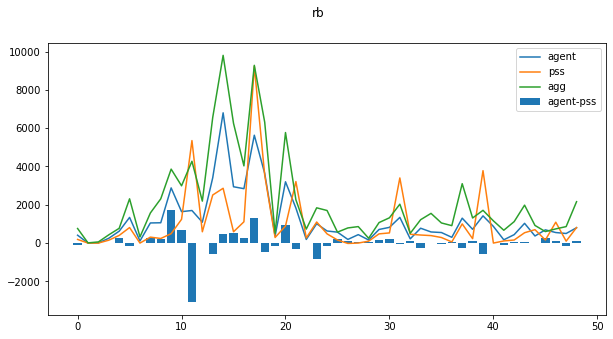

In [41]:
obj = 'rb'
data = pd.read_csv(f'res/{obj}/trade/sum.csv')
data1 = pd.read_csv(f'res/exp005/{obj}/sum.csv')
fig, ax,= plt.subplots(figsize=(10,5))
ax.plot(data.index, data.drl, label='agent')
ax.plot(data.index,data.pss, label='pss')
ax.plot(data.index,data['agg'], label='agg')
ax.bar(data.index, data.drl-data.pss-(data1.drl-data1.pss), label='agent-pss')
# ax2 = ax.twinx()
# ax.bar(data1.index, data1.drl-data1.pss, label='agent-psss')
# ax2 = ax.twinx()
# ax2.plot(data.index,data.avg_drl_sec, label='avg_drl_sec')
# ax2.plot(data.index,data.avg_pss_sec, label='avg_drl_sec')
plt.suptitle(obj)
# ax2 = fig.add_subplot(2,1,2)
plt.legend()

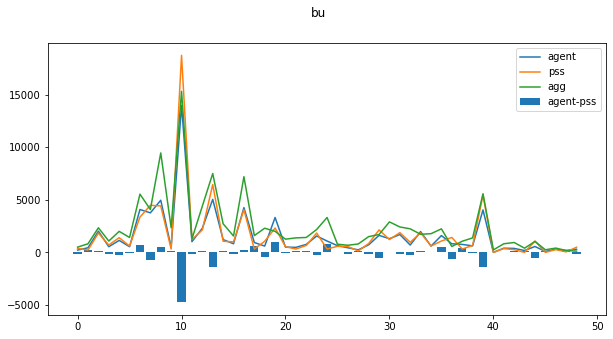

In [9]:
obj = 'bu'
# data = pd.read_csv(f'res/{obj}/trade/sum.csv')
data = pd.read_csv(f'res/exp005/{obj}/sum.csv')
fig, ax,= plt.subplots(figsize=(10,5))
ax.plot(data.index, data.drl, label='agent')
ax.plot(data.index,data.pss, label='pss')
ax.plot(data.index,data['agg'], label='agg')
ax.bar(data.index, data.drl-data.pss, label='agent-pss')
# ax2 = ax.twinx()
# ax2.plot(data.index,data.avg_drl_sec, label='avg_drl_sec')
# ax2.plot(data.index,data.avg_pss_sec, label='avg_drl_sec')
plt.suptitle(obj)
# ax2 = fig.add_subplot(2,1,2)
plt.legend()

3469128.289033547 3549277.4999999986 4736580.000000003


<BarContainer object of 56 artists>

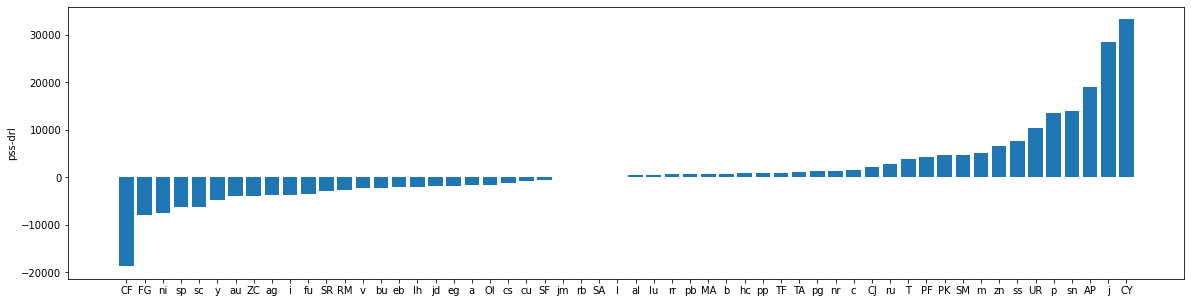

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
objs = ['rb', 'bu', 'OI', 'i']
# objs = ['rb','CF','nr','sc','al','UR','fu','MA','c','SR','y','TA','eg','v','SA','FG','ru','zn','eb','a','SF','T','au','PK','TF','l','bu']
dd = pd.read_csv('symbol_instrumentid2.csv')
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
# objs = objs+['all_list_'+i for i in objs]
# objs = obj_list
objs = dd.pz.unique()
# rest_objs = []
comment = 'exp003_fea'
# comment = 'queue'
cwd = os.path.join('res', comment)
a, b, c = 0, 0, 0
fin = []
cha = []
for obj in objs:
    file_path = os.path.join(cwd, obj, 'sum.csv')
    # file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
    if os.path.exists(file_path):
        fin.append(obj)
        data = pd.read_csv(file_path)
        # data = data[data.date<20220322]
        a+=data.drl.sum()
        b+=data.pss.sum()
        c+=data['agg'].sum()
        cha.append((obj, data.pss.sum()-data.drl.sum()))
# for obj in rest_objs:
#     # file_path = os.path.join(cwd, obj, 'sum.csv')
#     file_path = os.path.join(f'./res/{obj}/trade', 'sum.csv')
#     if os.path.exists(file_path):
#         fin.append(obj)
#         data = pd.read_csv(file_path)
#         a+=data.drl.sum()
#         b+=data.pss.sum()
#         c+=data['agg'].sum()
#         cha.append((obj, data.pss.sum()-data.drl.sum()))
cha = sorted(cha, key=lambda x:x[1])
# data = data[data.date!=20220119]
print(a,b,c)
a, b = [x[0] for x in cha], [x[1] for x in cha]
plt.subplots(figsize=(20,5))
plt.ylabel('pss-drl')
plt.bar(a, b)

In [10]:
# 绘制lambda与成交时间的关系图
models = ['baseline','queue','exp0005_fea','exp0007_1year', 'exp001_1year', 'exp001_fea', 'exp002_fea', 'exp003_fea', 'exp004_fea', 'exp008_fea','exp01_1year']
models = ['baseline_fea','exp0005_fea','exp001_fea','exp002_fea','exp003_fea', 'exp004_fea', 'exp008_fea', 'exp016_fea']#, '3state_feas_gamma2','baseline', 'exp01_1year','exp001_1year','exp0007_1year','queue','queue_agg']
dd = pd.read_csv('symbol_instrumentid2.csv')
objs = dd.pz.unique()
# objs = ['rb','i']
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
# objs = ['sc']
# models = models+['3state_gamma_2','3state_gamma_5','3state_gamma_10','3state_gamma_50','queue']
# models = ['feas_exp01','exp01_1year']
resu = []
for model in models:
    tb = []
    for obj in objs:
        pth = os.path.join('res',model,obj)
        summary = 0
        ret = 0
        lens = 0
        for _, __, files in os.walk(pth):
            for file in files:
                if file.split('.')[0]!='sum' and int(file.split('.')[0])<20220322:
                    dat = int(file.split('.')[0])
                    data = pd.read_csv(os.path.join(pth, file))

                    summ = data.iloc[:,1:].sum()
                    lens += len(data)
                    summary += summ.stepn
                    ret += summ.drl
        try:
            tb.append([obj, summary/lens, ret])
        except ZeroDivisionError:
            print(model, obj)
    tb = pd.DataFrame(tb)
    resu.append([model, tb.iloc[:,1].mean(), tb.iloc[:,2].mean()])
        # summary.to_csv(os.path.join(pth, 'sum.csv'), index=False)
resu = pd.DataFrame(resu)
nme = resu.iloc[:,0].apply(lambda x:x.split('_')[0])
resu
# plt.scatter(nme.iloc[2:-1], resu.iloc[2:-1,1])
# plt.scatter(nme.iloc[2:-1], resu.iloc[2:-1,2])

,0,1,2
0,baseline_fea,20.753203,36194.998619
1,exp0005_fea,36.663208,37010.959486
2,exp001_fea,41.984438,36761.752858
3,exp002_fea,44.469421,37091.751843
4,exp003_fea,45.557896,36384.441804
5,exp004_fea,45.136053,36326.920955
6,exp008_fea,42.774902,36839.877962
7,exp016_fea,44.966067,36815.496724


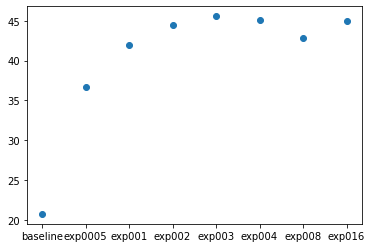

In [14]:
fig, ax1 = plt.subplots()
ax1.scatter(nme, resu.iloc[:,1])
# ax2 = ax1.twinx()
# ax2.scatter(nme.iloc[2:-1], resu.iloc[2:-1,2], color='r')

            model obj  win_rate    avg_loss
0        baseline  rb    1875.0   30.029333
1           queue  rb    2610.0   22.059387
2     exp0005_fea  rb    2335.0   26.730193
3   exp0007_1year  rb     771.0   72.665370
4    exp001_1year  rb    1116.0   45.990143
5      exp001_fea  rb    1981.0   29.472489
6      exp002_fea  rb     929.0   57.680301
7      exp003_fea  rb    1059.0   50.845137
8      exp004_fea  rb    1030.0   56.878641
9      exp008_fea  rb     985.0   59.873096
10    exp01_1year  rb     761.0   73.935611
11            pss  rb     489.0  103.905930


/tmp/ipykernel_36569/3178761684.py:42: RuntimeWarning: divide by zero encountered in true_divide
  y = 50000/x


(0.0, 3000.0)

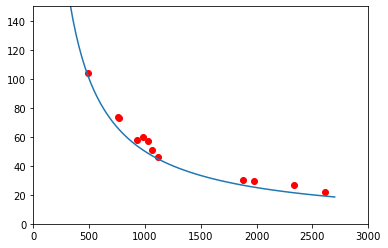

In [47]:
# 计算胜率与赔率
models = ['baseline','queue','exp0005_fea','exp0007_1year', 'exp001_1year', 'exp001_fea', 'exp002_fea', 'exp003_fea', 'exp004_fea', 'exp008_fea','exp01_1year']
dd = pd.read_csv('symbol_instrumentid2.csv')
objs = dd.pz.unique()
objs = ['rb']
clrs = ['r']
# rest_objs = [i for i in dd.pz.unique() if i not in objs]
# objs = ['pb']
# models = models+['3state_gamma_2','3state_gamma_5','3state_gamma_10','3state_gamma_50','queue']
# models = ['feas_exp01','exp01_1year']
resu = []
fig, ax = plt.subplots()
for obj, clr in zip(objs, clrs):
    tb = []
    for model in models:
        pth = os.path.join('res',model,obj)
        win_drl = 0
        win_pss = 0
        loss_drl = []
        loss_pss = []
        lens = 0
        for _, __, files in os.walk(pth):
            for file in files:
                if file.split('.')[0]!='sum' and int(file.split('.')[0])<20220322:
                    dat = int(file.split('.')[0])
                    data = pd.read_csv(os.path.join(pth, file))
                    win_pss += (data.pss==0).sum()
                    win_drl += (data.drl==0).sum()
                    loss_drl.append(data[data.drl!=0].drl)
                    loss_pss.append(data[data.pss!=0].pss)
                    lens += len(data)
        tb.append([model, obj, lens*(1-win_drl/lens), pd.concat(loss_drl).mean()])
    tb.append(['pss', obj, lens*(1-win_pss/lens), pd.concat(loss_pss).mean()])
    # resu.append([model, tb.iloc[:,1].mean(), tb.iloc[:,2].mean()])
        # summary.to_csv(os.path.join(pth, 'sum.csv'), index=False)
# resu = pd.DataFrame(resu)
# nme = resu.iloc[:,0].apply(lambda x:x.split('_')[0])
    tb = pd.DataFrame(tb,columns=['model','obj','win_rate','avg_loss'])
    print(tb)
    ax.scatter(tb.win_rate, tb.avg_loss, color=clr)
x = np.linspace(0,2700,100)
y = 50000/x
ax.plot(x,y)

ax.set_ylim(0, 150)
ax.set_xlim(0, 3000)

# plt.show()

In [457]:
# 根据所有数据计算sum
objs = dd.pz.unique()
models = ['exp0005_fea','exp001_fea','exp002_fea','exp003_fea', 'exp004_fea', 'exp008_fea', 'exp016_fea','baseline_fea']#, '3state_feas_gamma2','baseline', 'exp01_1year','exp001_1year','exp0007_1year','queue','queue_agg']
for model in models:
    for obj in objs:
        pth = os.path.join('res',model,obj)
        summary = []
        for _, __, files in os.walk(pth):
            for file in files:
                if file.split('.')[0]!='sum':# and int(file.split('.')[0])<20220322:
                    dat = int(file.split('.')[0])
                    data = pd.read_csv(os.path.join(pth, file))

                    summ = data.iloc[:,1:].sum()
                    lens = len(data)
                    # summary += summ.stepn

                    summ['date'] = dat
                    summ['avg_drl_sec'] = summ.stepn/lens
                    summ['avg_pss_sec'] = summ.filled_seconds/lens

                    summ = summ[['date','drl','pss','agg','avg_drl_sec','avg_pss_sec']]
                    summary.append(summ.to_frame().T)
            
        summary = pd.concat(summary, axis=0)
        summary.to_csv(os.path.join(pth, 'sum.csv'), index=False)

In [456]:
objs

['rb']

In [443]:

def log_data_generator(dat, obj='rb',
                       log_path='/Data/database/logs_thunder',
                       tick_path='/Data/database/data_zltick/'):
        # [x.agg_cost, x.pss_cost, ]
    tick_path = os.path.join(tick_path, obj)
    log_path = os.path.join(log_path, dat)
    if not os.path.exists(os.path.join(tick_path, dat+'.csv')):
        return
    if not os.path.exists(os.path.join(log_path,'acc_sub.txt')):
        return
    try:
        a, acc = SingleDayHDAll('acc_sub.txt', log_path, dat) 
    except KeyError:
        print('keyerror!')
        return

    tick_data, contract = preprocess(tick_path, dat+'.csv')
    tick_data = tick_data.reset_index()
    tick_data['ticktime'] = tick_data.datetime.astype('str').apply(lambda x:x.split(' ')[1])
    tick_data['tickdate'] = tick_data.datetime.dt.date
    all_tick_len = len(tick_data)
    last_date = tick_data.tickdate.iloc[0]

    jud = (a.ticker==obj)&(a.symbol==contract)&\
            (((a.fx>0)&(a.odprice==a.bidprice)) |\
            ((a.fx<0)&(a.odprice==a.askprice))
            )
    a = a[jud][['symbol', 'agg_cost', 'pss_cost', 'ticktime', 'fx', 'filled_value', 'filled_lots',
       'filled_seconds', 'filled_date', 'pv', 'filled_price',]]
    a['ticktime'] = a.ticktime.apply(lambda x:x+'00' if x.split('.')[1]=='0' else x)

    for _,trade in a.iterrows():
        
        if trade.isnull().any():
            continue

        tim = trade['ticktime']
        s, ms = tim.split('.')
        tims = s+'.000' if int(ms)<500 else s+'.500'
        tim = pd.to_datetime(trade.filled_date+' '+tims)

        if obj in ['m'] and int(tims.split(':')[0])>=21:
            # print('tim', tim, last_date)
            tim = pd.to_datetime(str(last_date)+' '+tims)
            # print('tim', tim, last_date)
        ord = tick_data.datetime.searchsorted(tim, side='right')-1
        # ord = tick_data[tick_data.ticktime==tim].index[0]
        if ord-100+1<0:
            continue
        if ord+120>=all_tick_len:
            continue
        trade_data = tick_data.iloc[ord-100+1:ord+600+1]
        periods = ['3s','10s','30s','60s','5min','15min']
        avgs = [i+'_avg' for i in periods]
        hls = [i+'_hl' for i in periods]
        cos = [i+'_co' for i in periods]
        trade_data = trade_data[['bid','ask','bidv','askv','volume']+avgs+hls+cos]
        # trade_data['bid'] = trade_data['bid']/10
        # trade_data['ask'] = trade_data['ask']/10
        # yield trade.fx, trade.agg_cost, trade.pss_cost, trade_data.values
        yield trade, trade_data.values

In [453]:
from datetime import timedelta, date
next(log_data_generator('20220511'))

(symbol                  rb2210
 agg_cost                  10.0
 pss_cost                   0.0
 ticktime          21:06:20.500
 fx                           1
 filled_value            4625.0
 filled_lots                  1
 filled_seconds             0.5
 filled_date           20220510
 pv                        10.0
 filled_price            4625.0
 Name: 2022-05-10 21:06:21, dtype: object,
 array([[16.        , 17.        , -0.10358033, ..., -2.        ,
         12.        ,  0.        ],
        [16.        , 17.        , -0.32120547, ..., -2.        ,
         12.        ,  0.        ],
        [16.        , 17.        , -0.50372976, ..., -2.        ,
         12.        ,  0.        ],
        ...,
        [10.        , 11.        , -0.66519362, ...,  1.        ,
         -4.        ,  0.        ],
        [10.        , 11.        , -0.2510038 , ...,  1.        ,
         -4.        ,  0.        ],
        [10.        , 11.        , -0.28610465, ...,  1.        ,
         -4.    

In [ ]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
def backtest(obj, gpus, comment, model_name):
    # gpu_id = int(sys.argv[2])
    gpu_id = gpus if gpus==0 else gpus.get()
    print(f'{obj} backtest begins, gpu id:{gpu_id}')
    mdir = '/Data/hongyuan'
    # direct = int(sys.argv[3])
    tick = pd.read_csv('symbol_instrumentid2.csv')
    tick = tick[tick.pz==obj].tick.values[0]
    chengshu = get_unit_cost(obj.lower())[1]

    if model_name == 'objs':
        model_name = obj

    buy_path = os.path.join(mdir, comment, f'{model_name}1')
    sell_path = os.path.join(mdir, comment, f'{model_name}-1')
    if not os.path.exists(buy_path) or not os.path.exists(sell_path):
        raise NotImplementedError
    if len(os.listdir(buy_path))==0 or len(os.listdir(sell_path))==0:
        raise NotImplementedError
    start_date = date(2022, 5, 12)
    end_date = date(2022, 6, 29)

    dates = [n.strftime("%Y%m%d") for n in daterange(start_date, end_date)]


    # args.cwd = './executioner_D3QN_sell'
    summary = []


    for dat in dates:
        b = []
        c = []
        not_trade_date = True
        # for dir, agg, pss, trade in log_data_generator(dat):
        try:
            for trade, tdata in log_data_generator(dat, obj):
                not_trade_date = False
                state = env.reset(tdata)
                done = False
                stepn = 0
                action = exec.policy(state)
                while not done:
                    state, reward, done, _ = env.step(action)  # different
                    action = exec.policy(state)
                    stepn += 1
                b.append([stepn/2.0, tick*chengshu*(1-reward), trade.pss_cost, trade.agg_cost]) 
                c.append(trade)
            if not_trade_date:
                continue
            b = pd.DataFrame(b, columns=['stepn','drl','pss','agg']).reset_index().drop('index', axis=1)
            c = pd.DataFrame(c).reset_index().drop('index', axis=1)
            c = pd.concat([b,c], axis=1)

            c['drl'] = c.apply(lambda x:x.pss if x.filled_seconds<=x.stepn else x.drl, axis=1)
            c['drl'] = c.apply(lambda x:x.pss if x.stepn==300 and x.filled_seconds>300 else x.drl, axis=1)
            c = c[['ticktime', 'drl','pss','agg','stepn','filled_seconds']]

            if model_name != obj:
                save_path = os.path.join('res', comment, f'{model_name}_{obj}')
            else:
                save_path = os.path.join('res', comment, f'{obj}')

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            c.to_csv(os.path.join(save_path, str(dat)+'.csv'), index=False)
            summ = c.iloc[:,1:].sum()
            lens = len(c)
            summ['date'] = dat
            summ['avg_drl_sec'] = summ.stepn/lens
            summ['avg_pss_sec'] = summ.filled_seconds/lens
            summ = summ[['date','drl','pss','agg','avg_drl_sec','avg_pss_sec']]
            summary.append(summ.to_frame().T)
            print(summ.to_frame().T)
        except (ValueError, IndexError) as e:
            print(obj)
            print('data error!')
        except Exception as e:
            print(e)
            print('gg')
    
    summary = pd.concat(summary, axis=0)
    summary.to_csv(os.path.join(save_path, 'sum.csv'), index=False)

    gpus.put(gpu_id)
    print(f'{obj} backtest ends successfully, release gpu id:{gpu_id}')
    os.kill(os.getpid(), signal.SIGTERM)
